# Time Series Modeling - General Assembly Data Science Final Project
Melissa Medeiros - October 29, 2018

## Project Overview 
This Project has been an analyis of the [Mumps data series](www.link.com), which includes monthly reported cases of mumps in NYC from 1928 - 1972. In a [previous notebook](www.link.com) we performed exploratory analysis on this time series to learn more about it. We also experimented with different time series techniques [here](www.link.com). 

In this notebook we will refine our SARIMA model:
- Examine time series, ACF and PACF plots to select parameters
- Run grid search on all combinations of potential parameters and select optimized model
- Fit the model on our training data (observations from 1928 - 1969) and compare the fitted values to the actuals. 
- Project forward and compare to 1970 actuals that have been withheld as a test set

## Setup

In [1]:
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload 

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default chart size for notebook

# The series
The data set consists of the monthly reported cases of mumps in NYC in 1928 - 1972

In [2]:
mumps = pd.read_csv('data/nyc_mumps.csv', converters={'Month':pd.to_datetime})
mumps.columns = ['month','mumps']
mumps.head()

,month,mumps
0,1928-01-01,124
1,1928-02-01,132
2,1928-03-01,193
3,1928-04-01,144
4,1928-05-01,195


#### Save 1970 and beyond as the 'future' 
We will ignore this for all our EDA and training / testing

In [3]:
START_FORECAST = '1970-1-1'
END_FORECAST = '1972-2-1'

In [4]:
the_future = mumps[mumps.month>=START_FORECAST]
the_future.to_csv('data/actuals_1970-1972.csv') # will use in our forecasting tool

mumps = mumps[mumps.month<START_FORECAST]

In [5]:
mumps.tail()

,month,mumps
499,1969-08-01,283
500,1969-09-01,158
501,1969-10-01,223
502,1969-11-01,212
503,1969-12-01,333


#### Plot the series

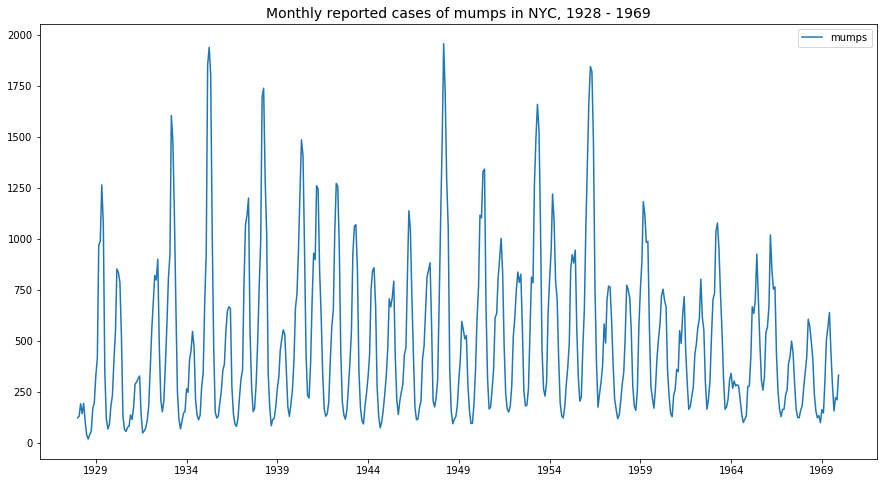

In [6]:
# Plot mumps
plt.title('Monthly reported cases of mumps in NYC, 1928 - 1969', fontsize=14)
plt.plot(mumps.month, mumps.mumps)
plt.legend(['mumps'])
plt.show()

#### Zoom in on a shorter time period

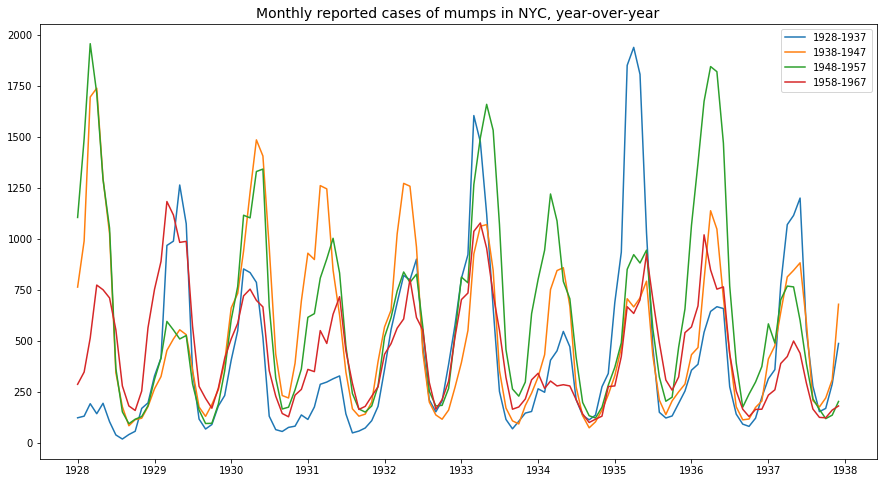

In [7]:
# zoom in on a shorter time period
plt.title('Monthly reported cases of mumps in NYC, year-over-year', fontsize=14)
plt.plot(mumps.month[:120], mumps.mumps[:120], label='1928-1937')  
plt.plot(mumps.month[:120], mumps.mumps[120:240], label='1938-1947')
plt.plot(mumps.month[:120], mumps.mumps[240:360], label='1948-1957')
plt.plot(mumps.month[:120], mumps.mumps[360:480], label='1958-1967')
plt.legend()
# replace x-axis labels with month or year1, year2, ... year10
plt.show()

#### Observe the seasonal (monthly) pattern in the series

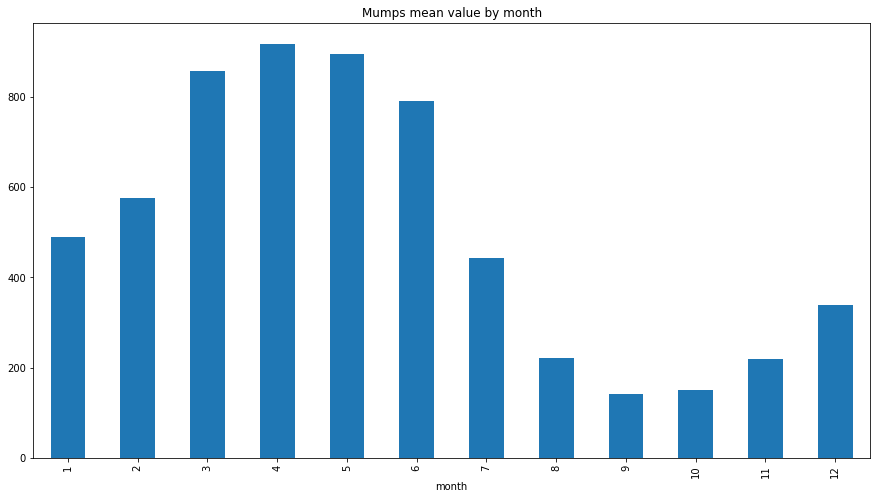

In [8]:
mumps.groupby(mumps.month.dt.month).mumps.mean().plot(kind='bar')
plt.title('Mumps mean value by month')
plt.show()

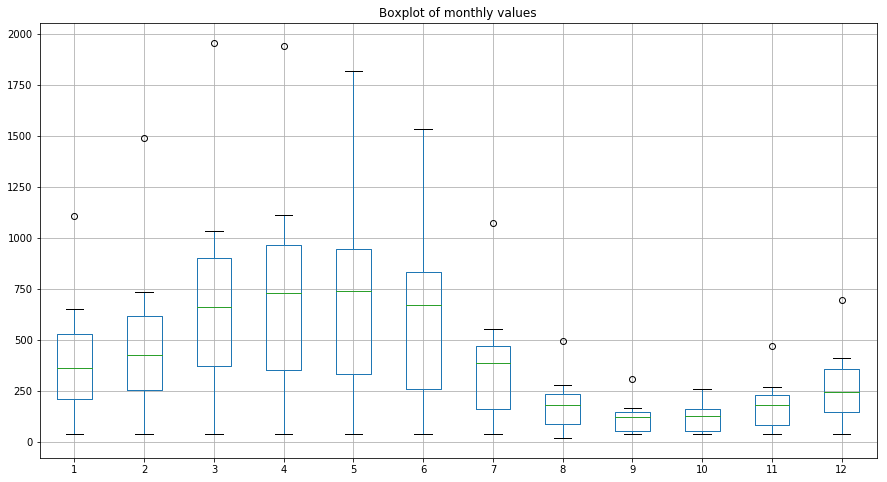

In [9]:
mumps.groupby(mumps.month.dt.month).mumps.describe().T.boxplot()
plt.title('Boxplot of monthly values')
plt.show()

#### Create a series object

In [10]:
# create a series obj - the modeling packages seem to prefer this format
mumps_series = mumps.set_index('month')

# we will be using the values from 1970 as our test set for each method
y_test = the_future[(the_future['month']>=START_FORECAST)&(the_future['month']<=END_FORECAST)].set_index('month')
y_test.head()

,mumps
month,
1970-01-01,330
1970-02-01,281
1970-03-01,354
1970-04-01,527
1970-05-01,463


# SARIMA Time Series Analysis
## SARIMA Modeling 
- S: Seasonal
- AR: Auto-Regressive
- I: Integrated
- MA: Moving Average

ARIMA(p,d,q)(P,D,Q)m = SARIMA
- p = auto-regressive
- d = order of integration
- q = moving-average

In [11]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from itertools import product 
from tqdm import tqdm_notebook

from SARIMA import tsplot, optimizeSARIMA, plotSARIMA
from TimeSeriesAnalysis import mean_absolute_percentage_error

### Test for stationarity
Correct any autocorrelation and seasonality

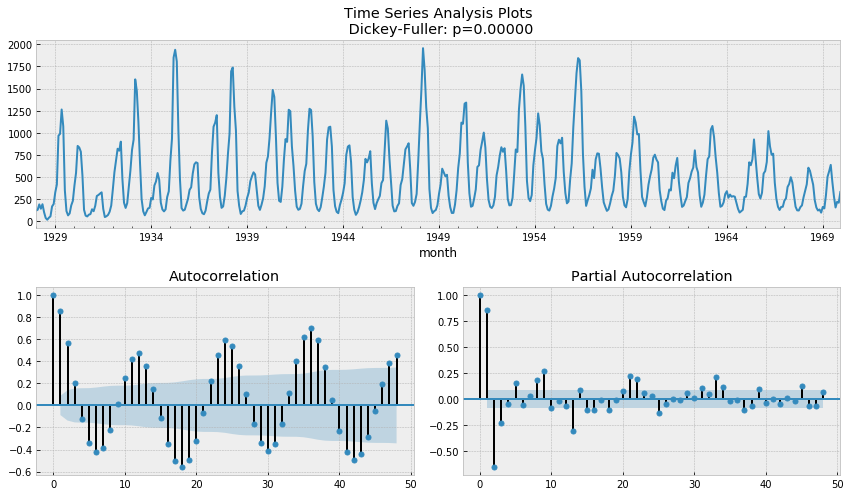

In [12]:
# Check the original series for stationarity
# The series is stationary according to the Dicky-Fuller test, but ACF shows high auto-correlation
# We need to remove the sesonalisty to correct this
tsplot(mumps_series.mumps, lags=48)

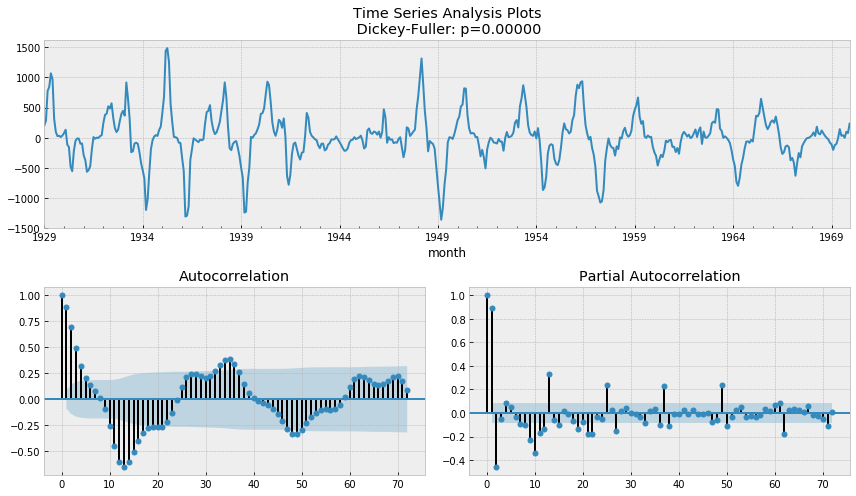

In [13]:
# Remove the annual (12 month) seasonality by differencing the series ("seasonal differencing")
# Now the monthly seasonality is removed, but the ACF still has too many signifcant lags
mumps_diff = mumps_series.mumps - mumps_series.mumps.shift(12)
tsplot(mumps_diff[12:], lags=72)

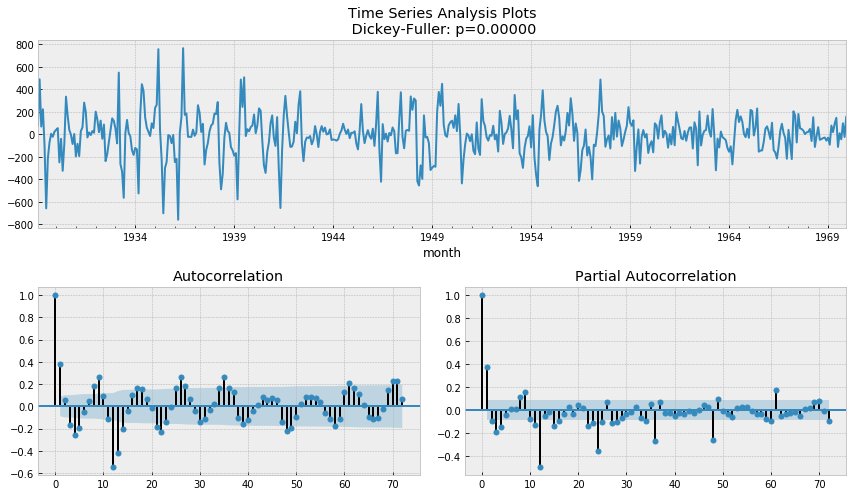

In [14]:
# Take a first order lag to correct the significant lags 
# We still have some significant lags 
mumps_diff = mumps_diff - mumps_diff.shift(1)
tsplot(mumps_diff[12+1:], lags=72)

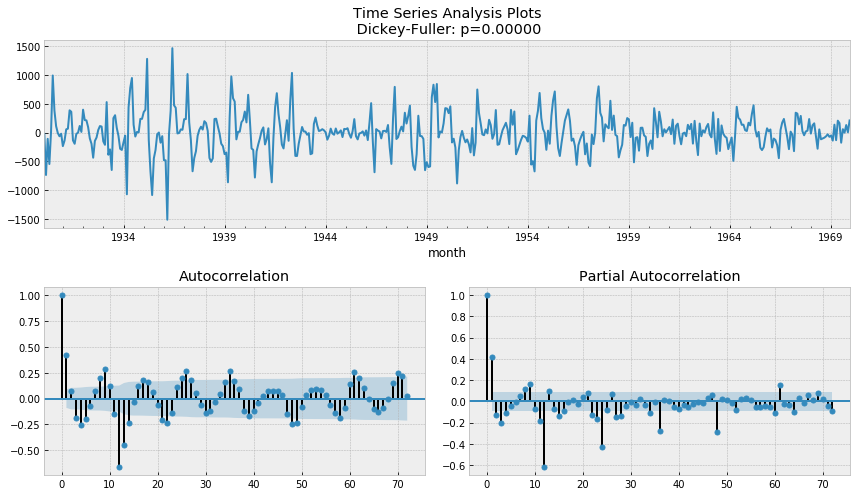

In [15]:
# Take another difference - second order?
mumps_diff = mumps_diff - mumps_diff.shift(12)
tsplot(mumps_diff[12+1+12:], lags=72)

### Grid search for SARIMA parameters 
Run the optimization function to select the best params from params_list

Compare models using AIC: 
- Measure of how much information is lost by the model (lower is better)
- AIC is a relative score used to compare multiple models

We will cycle through all possible combinations of parameters

In [16]:
# ps = auto-regressive component of the model
ps = range(0, 2) # PCAF?

# d = order of integration, AKA # of nonseasonal differences needed to make the series stationary
d = 2 # ?? d = 2 indicates a non-varying trend (0 = no trend, all ACF lags low, 1 = constant trend)
# we took the first and second (non-seasonal) differences 

# qs = moving average component 
# biggest significant lag on ACF after which most other lags become insignificant.
qs = range(0, 2) # last sig lag on ACF: 12


# P,D,Q = Seasonal versions of p,d,q parameters
# Ps = order of autoregression for the seasonal component of the model, derived from PACF
# Look at PACF for # of significant lags that are multiples of the season period length
Ps = range(4, 5) # PCAF shows sig lags as 11, 23, 35, 47... shifted the series

# D = order of seasonal integration
D = 1 # 1 = seasonal differeces applied, 0 = no seasonal differences

# Qs = order of moving average seasonal component 
Qs = range(0, 2) # ACF shows sig lag at 12 only

# s = seasonality, equals the season period length 
s = 12 # season length is 12 (monthly)

# create a list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [17]:
# run grid search to check all parameter combinations
result_table = optimizeSARIMA(mumps_series.mumps, parameters_list, d, D, s)

A Jupyter Widget

In [18]:
# results of grid search - lower AIC is better
result_table

,parameters,aic
0,"(1, 1, 4, 1)",6116.607100
1,"(0, 1, 4, 1)",6152.846298
2,"(1, 1, 4, 0)",6157.832125
3,"(0, 1, 4, 0)",6188.090707
4,"(1, 0, 4, 1)",6267.438431
5,"(0, 0, 4, 1)",6306.511464
6,"(1, 0, 4, 0)",6309.369354
7,"(0, 0, 4, 0)",6352.547033


### Build optimized model

In [19]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0] 

best_model=sm.tsa.statespace.SARIMAX(mumps_series.mumps, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=False)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              mumps   No. Observations:                  504
Model:             SARIMAX(1, 2, 1)x(4, 1, 1, 12)   Log Likelihood               -3050.304
Date:                            Sun, 28 Oct 2018   AIC                           6116.607
Time:                                    22:44:06   BIC                           6150.388
Sample:                                01-01-1928   HQIC                          6129.858
                                     - 12-01-1969                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2980      0.042      7.168      0.000       0.217       0.379
ma.L1         -1.0000     18.216   

### Check model residuals

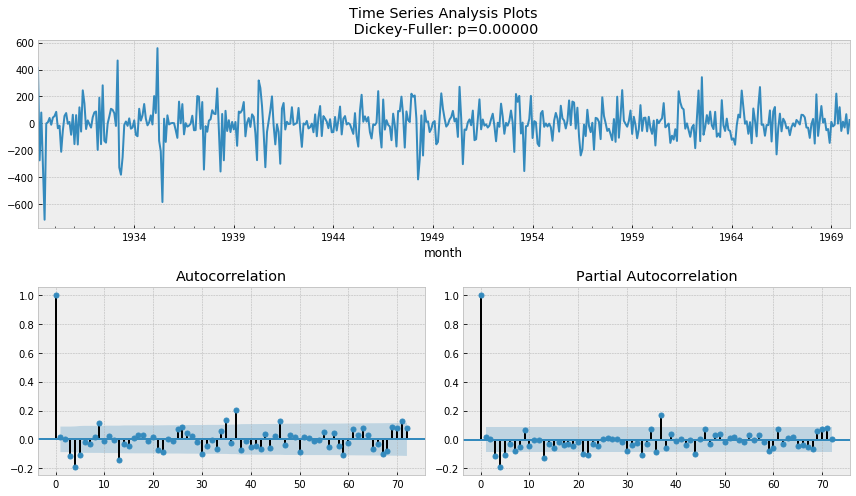

In [20]:
# inspect the residuals of the model - they look like noise with no significant lags on ACF or PACF
tsplot(best_model.resid[12+1+1:], lags=72)

## Create SARIMA Forecast

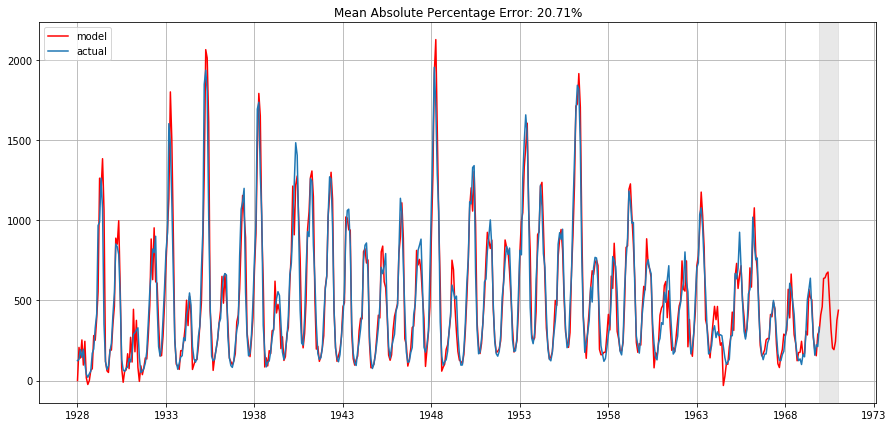

In [21]:
forecast = plotSARIMA(mumps_series, best_model, 12, s, d)

### Compare forecast to actuals 

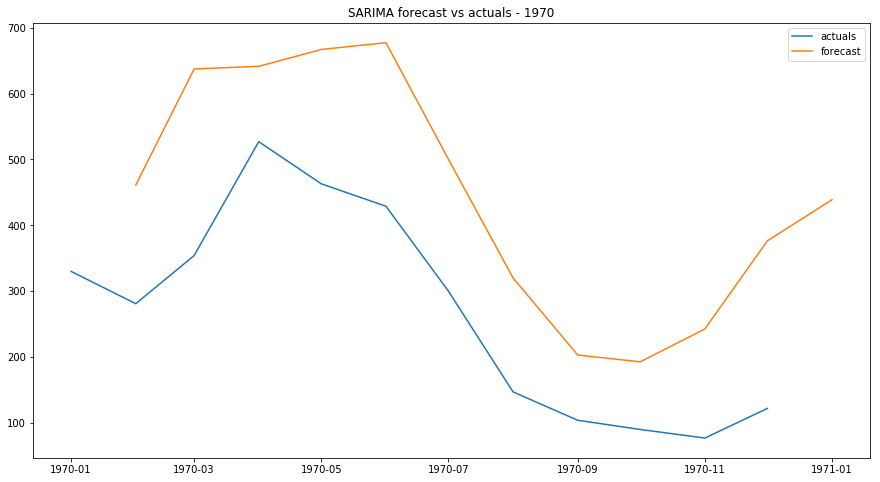

In [22]:
# plot forecast vs actuals
plt.plot(the_future.head(12).month, the_future.mumps.head(12), label='actuals')
plt.plot(forecast.tail(12).index, forecast.tail(12), label='forecast')
plt.legend()
plt.title('SARIMA forecast vs actuals - 1970')
plt.show()

In [23]:
# calculate errors
mse = mean_squared_error(the_future.mumps.head(12), forecast.tail(12))
mape = mean_absolute_percentage_error(the_future.mumps.head(12).values, forecast.tail(12).values)

print('SARIMA errors \nMean squared error: {:.2f}, \nMean absolute percentage error: {:.2f}%'.format(mse, mape))

SARIMA errors 
Mean squared error: 43520.09, 
Mean absolute percentage error: 107.14%


# Appendix

### Time Series Modeling
#### Interpreting ACF / PACF
Moving average (MA) 
- The ACF plot will help us identify the order of the MA model. 
- We can find the lag (the q value) for an MA series by determining when the ACF drops off sharply. 

Autoregressive (AR) 
- The ACF will go down gradually without any sharp cut-off.
- The PACF will cut off after the degree of the AR series (the p value). 
- Example: In an AR(1) series, the partial correlation function (PACF) will drop sharply after the first lag


#### AIC
Estimator for comparing models against other models
- Quality of model relative to each of the other models
- Estimates the relative information lost by the model
- When comparing models, the minimum AIC is preferred (indicates the least amount of info lost)
